In [8]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from scipy.stats import mannwhitneyu, ttest_ind, pearsonr, spearmanr
from tqdm import tqdm
import numpy as np 
import math
import seaborn as sns
from scipy.stats import ttest_ind


demos = ['women', 'black', 'hispanic', 'native american']
%matplotlib inline

### 1. Startup

In [9]:
def startup(start, end):
    """ 
    Takes in a start and end year and returns a dictionary of dataframes. Read in data from 
    IPEDS completions, university meta-data and demographic columns of interest.
    """
    
    unis = pd.read_csv('../../data/IPEDS/university_info/hd2021.csv', encoding='cp1252')
    unis = unis.set_index('UNITID')

    completions = {}
    for year in range(start, end+1):
        data              = pd.read_csv('../../data/IPEDS/completions/c%s_a.csv' % year)
        data              = data.set_index('UNITID')
        data              = data[data['AWLEVEL'] == 5]
        completions[year] = data

    demo_cols = ['CTOTALW', 'CAIANT', 'CBKAAT', 'CHISPT', 'CTOTALT']
    
    return unis, completions, demo_cols

unis, completions, demo_cols = startup(2011, 2021)

### 2. CS & NonCS

In [10]:
def cs_noncs(data):

    cs_map      = data['CIPCODE'].apply(lambda x : 11 <= x and x < 12)
    cs          = data[cs_map]
    cs_sum      = cs.groupby('UNITID').sum()

    noncs_map   = ~cs_map
    noncs       = data[noncs_map]
    noncs_sum   = noncs.groupby('UNITID').sum()

    cs_unis     = set(cs_sum.index.unique())
    noncs_unis  = set(noncs_sum.index.unique())
    common_unis = list(cs_unis.intersection(noncs_unis))

    cs_sum      = cs_sum.loc[common_unis]
    noncs_sum   = noncs_sum.loc[common_unis]

    return cs_sum, noncs_sum

def cs_noncs_allyears(completions):

    all_cs      = []
    all_noncs   = []
    
    for year in completions:
        data          = completions[year]
        cs, noncs     = cs_noncs(data)

        cs['year']    = year
        noncs['year'] = year

        all_cs.append(cs)
        all_noncs.append(noncs)
        
    all_cs    = pd.concat(all_cs)
    all_noncs = pd.concat(all_noncs)
    return all_cs, all_noncs

cs, noncs = cs_noncs_allyears(completions)

In [11]:
total_grads_cs  = cs.groupby('UNITID').sum()['CTOTALT']
total_grads_ncs = noncs.groupby('UNITID').sum()['CTOTALT']

total_grads_cs.name  = 'total_cs'
total_grads_ncs.name = 'total_noncs'

totals = pd.merge(total_grads_cs, total_grads_ncs, left_index=True, right_index=True)

# totals.to_csv('../../out/totals.csv')

In [52]:
national_all_cs         = cs.groupby('year').sum()['CTOTALT']
national_women_cs       = cs.groupby('year').sum()['CTOTALW']
national_black_cs       = cs.groupby('year').sum()['CBKAAT']
national_hispanic_cs    = cs.groupby('year').sum()['CHISPT']

national_all_ncs        = noncs.groupby('year').sum()['CTOTALT']
national_women_ncs      = noncs.groupby('year').sum()['CTOTALW']
national_black_ncs      = noncs.groupby('year').sum()['CBKAAT']
national_hispanic_ncs   = noncs.groupby('year').sum()['CHISPT']

### 3. Compute Demographic Percentages

In [15]:
def make_percents(cs, noncs, demo_cols):
    cs      = cs.set_index(['year'], append=True)
    noncs   = noncs.set_index(['year'], append=True)

    cs_pct      = cs.apply(lambda x:    x[demo_cols] / x['CTOTALT'], axis = 1)
    noncs_pct   = noncs.apply(lambda x: x[demo_cols] / x['CTOTALT'], axis = 1)

    return cs_pct, noncs_pct

cs_pct, noncs_pct = make_percents(cs, noncs, demo_cols)


In [41]:
cs_sem  = cs_pct.reset_index().groupby('year').apply(lambda x: pd.Series({'mean':x['CBKAAT'].mean(), 'sem': x['CBKAAT'].sem()}))
ncs_sem = noncs_pct.reset_index().groupby('year').apply(lambda x: pd.Series({'mean':x['CBKAAT'].mean(), 'sem': x['CBKAAT'].sem()}))

In [71]:
cs.groupby('year').sum()['CBKAAT']

year
2011    4455
2012    4886
2013    5544
2014    5536
2015    5785
2016    5725
2017    6152
2018    6679
2019    7435
2020    7844
2021    8837
Name: CBKAAT, dtype: int64

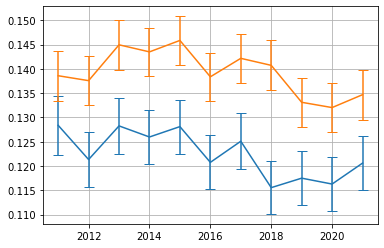

In [43]:
plt.errorbar(cs_sem.index, cs_sem['mean'], yerr=cs_sem['sem'], label='CS', capsize=5)
plt.errorbar(ncs_sem.index, ncs_sem['mean'], yerr=ncs_sem['sem'], label='CS', capsize=5)
plt.grid()

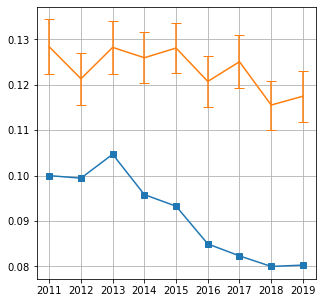

In [57]:
plt.figure(figsize=(5, 5))
plt.plot(national_black.index[:-2], (national_black / national_all)[:-2], marker='s', label='National CS')
# plt.twinx()
plt.errorbar(cs_sem.index[:-2], cs_sem['mean'][:-2], yerr=cs_sem['sem'][:-2], label='Institutional Level CS', capsize=5)
plt.grid()


In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(national_black.index[:-2], (national_black / national_all)[:-2], marker='s', label='National CS')
# plt.twinx()
plt.errorbar(cs_sem.index[:-2], cs_sem['mean'][:-2], yerr=cs_sem['sem'][:-2], label='Institutional Level CS', capsize=5)
plt.grid()
